In [22]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random, jit, vmap, value_and_grad

In [23]:
import dmeq

In [24]:
seed = random.PRNGKey(42)

In [25]:
import pickle
from dataclasses import dataclass
from typing import Any, Sequence
from jaxtyping import PyTree, Float, Array
from flax import linen as nn
from jax.nn import sigmoid

@dataclass
class Surrogate():
    model: Any
    params: PyTree
    param_keys: Sequence[str]
    param_stats: Sequence[Float[Array, 'input_dim']]
    output_ranges: Sequence[Sequence[int]]
    output_stats: Sequence[Sequence[Float[Array, 'output_dim']]]
    
    def run(self, p):
        input_array = jnp.array([p[k] for k in self.param_keys])
        standardised_input = (input_array - self.param_stats[0]) / self.param_stats[1]
        output = self.model.apply(self.params, standardised_input)
        standardised_result = jnp.concatenate([
            output[self.output_ranges[i][0]:self.output_ranges[i][1]] *
                self.output_stats[i][1] + self.output_stats[i][0]
            for i in range(len(self.output_ranges))
        ])
        reshaped = jnp.reshape(
            standardised_result,
            (
                len(self.output_ranges),
                (self.output_ranges[0][1] - self.output_ranges[0][0])
            )
        )
        delta = 1e-10
        return jnp.minimum(jnp.maximum(reshaped, delta), 1. - delta)

class MLP(nn.Module):
    units: int
    n_hidden: int
    n_output: int

    def setup(self):
        self.layers = [nn.Dense(self.units) for _ in range(self.n_hidden)]
        self.output_layer = nn.Dense(self.n_output)

    def __call__(self, inputs):
        x = inputs
        for i, lyr in enumerate(self.layers):
            x = lyr(x)
            x = nn.relu(x)
        return self.output_layer(x)

with open('eq_surrogate', 'rb') as f:
    surrogate = pickle.load(f)

In [26]:
def prev_stats(params, eir, eta, impl):
    p = dmeq.default_parameters()
    (
        p['kb'],
        # p['ub'],
        p['b0'],
        # p['IB0'],
        # p['kc'],
        # p['uc'],
        # p['IC0'],
        # p['phi0'],
        # p['phi1'],
        # p['PM'],
        # p['dm'],
        # p['kd'],
        # p['ud'],
        # p['d1'],
        # p['ID0'],
        # p['fd0'],
        # p['gd'],
        # p['ad0'],
        # p['rU'],
        # p['cD'],
        # p['cU'],
        # p['g_inf']
    )= params
    p['EIR'] = eir
    p['eta'] = eta
    solution = impl(p)
    return jnp.array([
        solution[0, 3:10].sum() / solution[2, 3:10].sum(), # Prev 2 - 10
        solution[0, 10:].sum() / solution[2, 10:].sum(), # Prev 10+
        solution[1, :5].sum() / solution[2, :5].sum(), # Inc 0 - 5
        solution[1, 5:15].sum() / solution[2, 5:15].sum(), # Inc 5 - 15
        solution[1, 15:].sum() / solution[2, 15:].sum() # Inc 15+
    ])

In [27]:
def prev_stats_multisite(params, eirs, etas, impl):
    return jnp.ravel(vmap(prev_stats, in_axes=[None, 0, 0, None])(params, eirs, etas, impl))

In [28]:
population = 100_000
EIRs = jnp.array([0.05, 3.9, 15., 20., 100., 150., 418.])
etas = 1. / (random.normal(seed, shape=EIRs.shape, dtype=jnp.float64) * 2 * 365 + 20*365)

In [29]:
def prev(b0, kb, impl):
    return prev_stats([b0, kb], EIRs[0], etas[0], impl)[0]

In [30]:
n = 50
b0 = jnp.linspace(0, 1, num=n)
kb = jnp.linspace(0, 5, num=n)
b0, kb = jnp.meshgrid(b0, kb)
dmeq_prev_space, dmeq_prev_grad = vmap(
    vmap(
        value_and_grad(prev),
        in_axes=(0, 0, None),
        out_axes=0
    ),
    in_axes=(1, 1, None),
    out_axes=1
)(b0, kb, dmeq.solve)
surr_prev_space, surr_prev_grad = vmap(
    vmap(
        value_and_grad(prev),
        in_axes=(0, 0, None),
        out_axes=0
    ),
    in_axes=(1, 1, None),
    out_axes=1
)(b0, kb, surrogate.run)

In [31]:
from matplotlib import cm

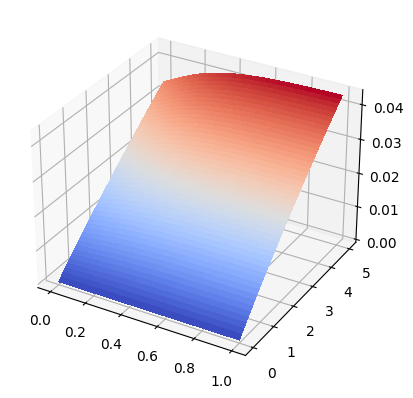

In [32]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(b0, kb, dmeq_prev_space, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

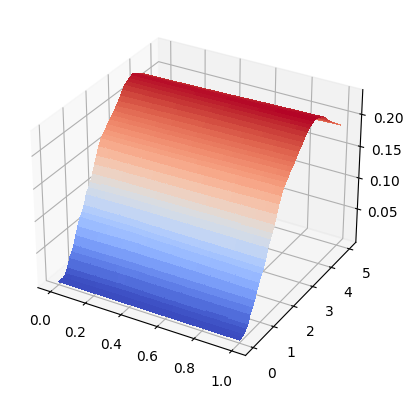

In [33]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(b0, kb, surr_prev_space, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

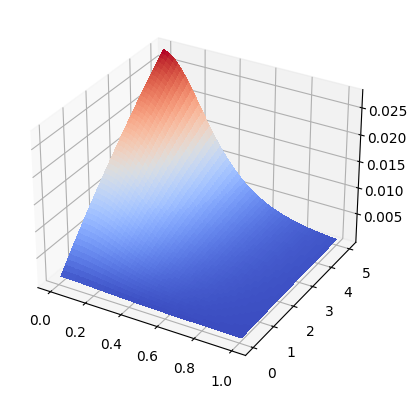

In [34]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(b0, kb, dmeq_prev_grad, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

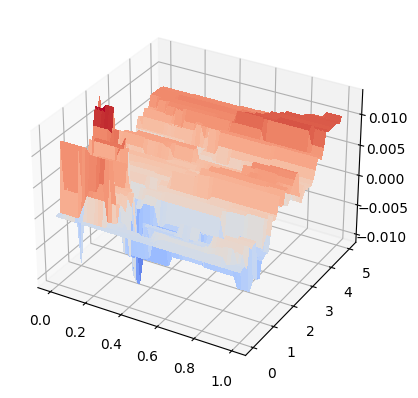

In [35]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(b0, kb, surr_prev_grad, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)